# DengAI
This project comes from the challenge proposed by [DRIVENDATA](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/). The goal consists of predicting how many dengue fever cases occur in two different cities. In order to do so, they provide a set of standard features that include aspects such as temperature, level of vegetation, etc.

It is important to state that since our intention is to predict the number of cases this is a regression problem. However, if we quantize the ```y``` labels we might also consider a classification problem, although we leave such task for another analysis.

---
Antonio Rodríguez-Hidalgo (arodh91@gmail.com)

2020

## Reading data

In [1]:
import pandas as pd
import os
import numpy as np

def read_data(data_file):
    data_structure = pd.read_csv(os.path.join('data',data_file))
    return data_structure

features = read_data('dengue_features_train.csv');
labels = read_data('dengue_labels_train.csv');
print('Training data readed!')

# We mix features and labels in a single dataset for commodity
features['total_cases']=labels['total_cases']
# Number of cities
print('Cities: {}'.format(features.city.unique()))
model_season_name = 'GradientBoosting';
model_trend_name = 'GradientBoosting';


Training data readed!
Cities: ['sj' 'iq']


In order to grasp the dataset we focus on one of the cities. Then, we can replicate our analyses with the other one.

In [2]:
# We split data for the two cities
city = 'sj'; # sj, iq
city_data = features[features['city'] == city]
labels = labels[labels['city'] == city]

city_data.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

# Data imputation
We check out how many of the features are missing (NaN) columnwise. It is important to appoint such values, since models might be affected by those points.

In [3]:
missing = {}
for col in city_data:
    missing_no = city_data[col].isna().sum()
    if missing_no != 0:
        missing[col] = missing_no;

pd.DataFrame(missing.values(), index = missing.keys(), columns=['Number of missing elements'])

,Number of missing elements
ndvi_ne,191
ndvi_nw,49
ndvi_se,19
ndvi_sw,19
precipitation_amt_mm,9
reanalysis_air_temp_k,6
reanalysis_avg_temp_k,6
reanalysis_dew_point_temp_k,6
reanalysis_max_air_temp_k,6
reanalysis_min_air_temp_k,6


In [4]:
from math import radians
# T = 52;
# dc = 1;
# phase = 2*radians(180)/T*30;
# sin_signal = (np.sin(2*radians(180)*np.arange(0,len(city_data))/T+phase));
# sin_signal =sin_signal*(sin_signal>0)

T = 104;
dc = 1;
phase = 2*radians(180)/T*50;
sin_signal = np.abs(np.sin(2*radians(180)*np.arange(0,len(city_data))/T+phase));


city_data.insert(0,'sin_signal',0.0)
city_data['sin_signal'].values[:] = sin_signal;
# plt.plot(sin_signal)
# plt.plot(X['weekofyear']/52)

We observe that some of these could be estimated using alternative features. That is hte example of "station_avg_temp_c", which could be estimated using "station_max_temp_c" and "station_min_temp_c" if they existed. Same could happen with "reanalysis_avg_temp_k". 

Nevertheless, since we are working with temporal series data it seems reasonable enough to interpolate the missing values using the data that we already know. This might be effective if the missing values are sparsely distributed.

In [5]:
for col in missing.keys():
    # We don't use the 'inplace' parameter since it shows the SettingWithCopyWarning.
    city_data[col].values[:] = city_data[col].interpolate(inplace=False)

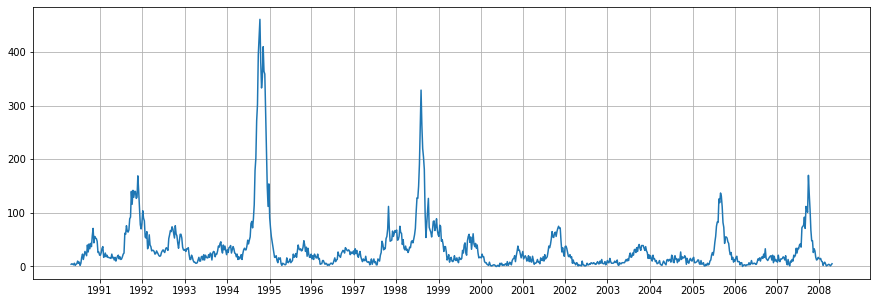

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(city_data['total_cases'])
plt.xticks(city_data.loc[city_data['weekofyear']== 1]['year'].index, labels = city_data.loc[city_data['weekofyear']== 1]['year']);
plt.grid()

Having a look at the temporal data shows that there are certain years where there were plenty of cases of Denge, as it occurred during 1994 and 1998. Moreover, we observe some seasonal effect, since there is a significant increase in the number of cases normally after mid-year. Consequently, we will attempt to have a deeper grasp of this effect.

# Studying correlation
It is quite important to understand what is the correlation between our existing features. An interesting fact is that correlation allows to measure some degree of similarity in a linear way, which means that two features that show a big value of such score can be linearly obtained from each other. This means that using features with a significant degree of correlation might worsen the performance of a model, since we would be feeding it using data that is redundant. Consequently, we need to minimize the number of features that are strongly correlated.

On the contrary, features that are highly correlated with the labels, denoted ```total_cases```, are highly desirable since they can be helpful to make our predictions.

In [7]:
# We study each feature independently and how it relates with the rest
from DengAI_utils import compute_correlation
correlation_matrix = compute_correlation(city_data);

We can observe that some of the features are strongly correlated, as it happens with ```ndvi_``` features and ```reanalysis_air_temp_k``` and ```reanalysis_avg_temp_k```.

If we focus on the correlation between ```total_cases``` and our feature-set we obtain the following graph, which depicts that for the ```city=iq``` the top features are ```season```, a humidity variable and three temperature variables. Notice that these will change for ```city=sj```.

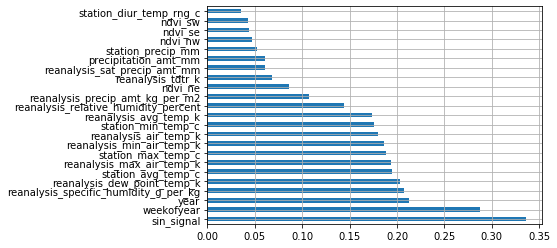

In [8]:
correlation_matrix.total_cases.drop('total_cases').apply(abs).sort_values(ascending=False).plot.barh();
plt.grid()

We can get a ranking with such scores and use it later to train our model.

In [9]:
season_features = correlation_matrix.total_cases.drop('total_cases').apply(abs).sort_values(ascending=False)
n_features =4;
season_features = season_features.drop('reanalysis_dew_point_temp_k')[:n_features]
season_features

sin_signal                               0.336341
weekofyear                               0.287134
year                                     0.212690
reanalysis_specific_humidity_g_per_kg    0.206942
Name: total_cases, dtype: float64

# Modelling seasonality
We attempt to model what happens with data using machine learning without any kind of temporal analysis, just for fun.

In [10]:
from sklearn.model_selection import train_test_split 

X = city_data[season_features.index];
# X_pca = city_pcaed;
y = labels;

i_train, i_test = train_test_split(range(len(X.index)), train_size = .85, shuffle=False);

# We need to scale this data
X_train = X.iloc[i_train];
X_test = X.iloc[i_test];

# We need to scale labels as well.
y_train = y['total_cases'].iloc[i_train];
y_test = y['total_cases'].iloc[i_test]; 

n_splits = 10;

In [ ]:
from ML_utils import Regressors
model_season = Regressors.Regressors()
model_season.get_regressor(model_season_name)
model_season.get_TimeSeries_CV('neg_mean_squared_error', n_splits)
model_season.fit_model(X_train, y_train)
best_params_season = model_season.model.best_params_

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot( model_season.return_prediction(X_train), label='Prediction')
plt.plot(y_train.values, label='Labels')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot( model_season.return_prediction(X_test), label='Prediction')
plt.plot(y_test.values, label='Labels')
plt.grid()
plt.legend()

target_trend = (y_train-model_season.return_prediction(X_train))

# Anomaly detection
We predict the target variable for the whole sequence. We will consider an anomaly every data sample whose target is on top of $1\cdot \sigma$, consering that our target variable has a mean value around 0 and follows no apparent trend.

In [ ]:
target_trend = (y['total_cases']-model_season.return_prediction(X))
# Confidence interval
corr_val = []
for lag in np.arange(1,100):
    corr_val.append(target_trend.autocorr(lag = lag))
    
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(corr_val)
plt.grid()
plt.title('Autocorrelation')

plt.subplot(312)
plt.plot(target_trend)
plt.fill_between(np.arange(len(target_trend)), 
                 target_trend.mean()+target_trend.std(),
                 target_trend.mean()-target_trend.std(), color='gray', alpha=0.5)
plt.grid()
plt.title('Residual signal with twice its standard deviation interval ($1\sigma$).')

plt.subplot(313)
plt.hist(target_trend, bins = np.arange(-200,200,10));
plt.grid()
plt.title('Histogram of the residual signal.')

In [ ]:
y_anomaly = np.abs(target_trend)>(target_trend.std())
i_train_anomaly, i_test_anomaly = train_test_split(range(len(X.index)), train_size = .85, shuffle=True, stratify=y_anomaly, random_state=1492);

X_train = X.iloc[i_train_anomaly];
X_test = X.iloc[i_test_anomaly];

y_train = y_anomaly.iloc[i_train_anomaly];
y_test = y_anomaly.iloc[i_test_anomaly];



We consider that everything outside such interval is an anomaly. Consequently, we've got data to train a binary classifier.


In [ ]:
anomaly_y = target_trend > (2*target_trend.std())

from sklearn.ensemble import GradientBoostingClassifier
anomaly_model = GradientBoostingClassifier()
anomaly_model.fit(X_train, y_train)
y_pred = anomaly_model.predict(X_train);

plt.subplot(211)
plt.plot(y_train.values!= y_pred*1)
plt.title('XOR operation between predicted and train variables.')
plt.subplot(212)
plt.plot( y_test.values !=  anomaly_model.predict(X_test))

In [ ]:
city_data.insert(1,'anomaly',False);
city_data['anomaly'].values[:] = anomaly_model.predict(X);


# Trend detection

In [ ]:
aux_city_data = city_data[:];
aux_city_data['target_trend'] = target_trend;
correlation_matrix = compute_correlation(aux_city_data);
trend_features = correlation_matrix.target_trend.drop(['total_cases','target_trend']).apply(abs).sort_values(ascending=False).index[:n_features];
correlation_matrix.target_trend.drop(['total_cases','target_trend']).apply(abs).sort_values(ascending=False).plot.barh();
plt.grid()

In [ ]:
X = city_data[trend_features];
y = labels;

i_train, i_test = train_test_split(range(len(X.index)), train_size = .85, shuffle=False);

# We need to scale this data
X_train = X.iloc[i_train];
X_test = X.iloc[i_test];

# We need to scale labels as well.
y_train = y['total_cases'].iloc[i_train];
y_test = y['total_cases'].iloc[i_test]; 



In [ ]:
plt.figure(figsize=(15,15))
# trend_features = season_features.drop('weekofyear').index#season_features.drop('weekofyear').index;

n_weeks = 1;#52;
for i in range(n_features-1):
    plt.subplot(n_features+1,1,i+1)
    plt.plot(X_train.rolling(n_weeks,min_periods=1).mean()[trend_features[i]])
    plt.plot(X_train[trend_features[i]])
    plt.title(trend_features[i])

    

model_trend = Regressors.Regressors()
model_trend.get_regressor(model_trend_name)
model_trend.get_TimeSeries_CV('neg_mean_squared_error', n_splits)
model_trend.fit_model(X_train.rolling(n_weeks,min_periods=1).mean()[trend_features], y_train)
best_params_trend = model_trend.model.best_params_

In [ ]:
# GLOBAL MODEL
X = city_data;
y = labels;

i_train, i_test = train_test_split(range(len(X.index)), train_size = .85, shuffle=False);
# We need to scale this data
X_train = X.iloc[i_train];
X_test = X.iloc[i_test];

# We need to scale labels as well.
y_train = y['total_cases'].iloc[i_train];
y_test = y['total_cases'].iloc[i_test]; 

In [ ]:
y_pred = model_season.return_prediction(X_test[season_features.index])+model_trend.return_prediction(X_test[trend_features])
plt.plot(y_pred,label='prediction');
plt.plot(y_test.values,label='labels')
plt.legend()


# Forecasting

In [ ]:
X_train = city_data;
y_train = labels['total_cases'];

plt.figure(figsize=(15,5))
plt.plot(model_season.return_prediction(X_train[season_features.index]),label='season');
plt.plot(model_trend.return_prediction(X_train[trend_features]),label='trend');
plt.plot(y_train,label='label')
plt.legend()
plt.grid()


model_season = Regressors.Regressors()
model_season.get_regressor(model_season_name, input_params = best_params_season)
model_season.get_TimeSeries_CV('neg_mean_squared_error', n_splits)
model_season.fit_model(X_train[season_features.index], y_train)

target_trend = (y_train-model_season.return_prediction(X_train[season_features.index]))


model_trend = Regressors.Regressors()
model_trend.get_regressor(model_trend_name, input_params = best_params_trend)
model_trend.get_TimeSeries_CV('neg_mean_squared_error', n_splits)
model_trend.fit_model(X_train.rolling(n_weeks,min_periods=1).mean()[trend_features], target_trend)



In [ ]:
plt.figure(figsize=(15,5))
plt.plot(model_season.return_prediction(X_train[season_features.index]),label='season');
plt.plot(model_trend.return_prediction(X_train[trend_features]),label='trend');
plt.plot(y_train,label='label')
plt.legend()
plt.grid()


In [ ]:
unlabelled_features = read_data('dengue_features_test.csv');
unlabelled_features = unlabelled_features[unlabelled_features['city'] == city]


missing = {}
for col in unlabelled_features:
    missing_no = unlabelled_features[col].isna().sum()
    if missing_no != 0:
        missing[col] = missing_no;

pd.DataFrame(missing.values(), index = missing.keys(), columns=['Number of missing elements'])
for col in missing.keys():
    # We don't use the 'inplace' parameter since it shows the SettingWithCopyWarning.
    unlabelled_features[col].values[:] = unlabelled_features[col].interpolate(inplace=False)
    

# We compute sin_signal for the unlabelled dataset.
sin_signal_unlabelled = np.abs(np.sin(2*radians(180)*(np.arange(0,len(unlabelled_features))+len(city_data))/T+phase));
unlabelled_features.insert(0,'sin_signal',0.0);
unlabelled_features['sin_signal'].values[:] = sin_signal_unlabelled; 

# We detect anomalous data and create their corresponding labels.
X_test = unlabelled_features#[season_features.index];
X_test.insert(1,'anomaly',False);
X_test['anomaly'].values[:] = anomaly_model.predict(X_test[season_features.index]);

In [ ]:
y_season = model_season.return_prediction(X_test[season_features.index])
y_trend = model_trend.return_prediction(X_test[trend_features])
plt.plot(y_season,label='season')
plt.plot(y_trend,label='trend')
plt.grid()
plt.legend()

In [ ]:
y_pred_total = y_season+y_trend;

y_pred = pd.DataFrame(index = X_test.index+len(X))
y_pred.insert(0,'city','')
y_pred.insert(1,'year',0)
y_pred.insert(2,'weekofyear',0)
y_pred.insert(3,'total_cases',0.0)
y_pred['total_cases'] =y_pred_total;


plt.figure(figsize=(15,5))
plt.plot(y_train, label = 'Labelled data');
# plt.plot(y_scaler.inverse_transform(np.expand_dims(y_pred['total_cases'],axis=1)))
plt.plot(y_pred['total_cases'], label= 'Unlabelled data')
plt.grid()
plt.legend()



In [ ]:
# y_pred.to_csv('output_{}.txt'.format(city),index=False)